In [65]:
%matplotlib inline

import os
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import files


print('Using PyTorch version', torch.__version__)
files.upload()  # Manually upload the kaggle.json file

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Using PyTorch version 2.4.0+cu121


Saving kaggle.json to kaggle (3).json


In [66]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set proper permissions for the API key
!chmod 600 ~/.kaggle/kaggle.json

# Download the COVID-19 Radiography Database dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Unzip the downloaded dataset
!unzip covid19-radiography-database.zip -d 'COVID-19 Radiography Database'

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19 

In [67]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith(('png', 'jpg', 'jpeg'))]
            print(f'Found {len(images)} images in {class_name}')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        for c in self.class_names:
            self.images[c] = get_images(c)
        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [68]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [69]:
train_dirs = {
    'normal': '/content/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/images'
}

# Initialize the dataset with corrected paths
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10192 images in normal
Found 1345 images in viral
Found 3616 images in covid


In [70]:
test_dirs = {
    'normal': '/content/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Normal/masks',
    'viral': '/content/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks',
    'covid': '/content/COVID-19 Radiography Database/COVID-19_Radiography_Dataset/COVID/masks'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 10192 images in normal
Found 1345 images in viral
Found 3616 images in covid


In [84]:
from sklearn.utils.class_weight import compute_class_weight  # Import this for class weights calculation

class_names = ['normal', 'viral', 'covid']
class_labels = [0, 1, 2]  # Indices for classes
class_counts = [len(train_dataset.images[class_name]) for class_name in train_dataset.class_names]

# Compute class weights
class_weights = compute_class_weight('balanced', classes=class_labels, y=np.concatenate([
    np.full(count, i) for i, count in enumerate(class_counts)
]))

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [85]:
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

resnet18 = torchvision.models.resnet18(weights='DEFAULT')
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
resnet18 = resnet18.to(device)  # Move model to the device

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

Num of training batches 2526
Num of test batches 2526


In [74]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [88]:
def show_preds():
    resnet18.eval()  # Set the model to evaluation mode
    images, labels = next(iter(dl_test))
    images, labels = images.to(device), labels.to(device)  # Move to device
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

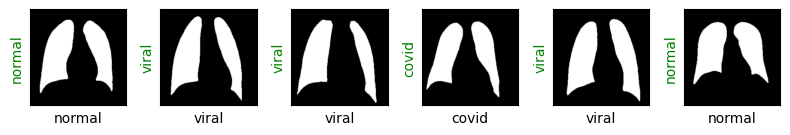

In [89]:
images, labels =next(iter(dl_test))
show_images(images, labels, labels)

In [86]:
def train(epochs):
    for epoch in range(epochs):
        resnet18.train()  # Set the model to training mode

        running_loss = 0.0
        for step, (images, labels) in enumerate(dl_train):
            images, labels = images.to(device), labels.to(device)  # Move to device

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = resnet18(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss

            # Print every 100 steps
            if step % 100 == 99:
                print(f'Epoch {epoch+1}/{epochs}, Step {step+1}/{len(dl_train)}, Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        # Validation phase
        validate(epoch)


In [87]:
def validate(epoch):
    resnet18.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dl_test:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(dl_test)
    accuracy = correct / total * 100
    print(f'Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')


In [90]:
train(epochs=1)

Epoch 1/1, Step 100/2526, Loss: 0.4008
Epoch 1/1, Step 200/2526, Loss: 0.3306
Epoch 1/1, Step 300/2526, Loss: 0.1905
Epoch 1/1, Step 400/2526, Loss: 0.2093
Epoch 1/1, Step 500/2526, Loss: 0.1802
Epoch 1/1, Step 600/2526, Loss: 0.1917
Epoch 1/1, Step 800/2526, Loss: 0.1436
Epoch 1/1, Step 900/2526, Loss: 0.1453
Epoch 1/1, Step 1000/2526, Loss: 0.0991
Epoch 1/1, Step 1100/2526, Loss: 0.1415
Epoch 1/1, Step 1200/2526, Loss: 0.1241
Epoch 1/1, Step 1300/2526, Loss: 0.0992
Epoch 1/1, Step 1400/2526, Loss: 0.0740
Epoch 1/1, Step 1500/2526, Loss: 0.1031
Epoch 1/1, Step 1600/2526, Loss: 0.0820
Epoch 1/1, Step 1700/2526, Loss: 0.0623
Epoch 1/1, Step 1800/2526, Loss: 0.0927
Epoch 1/1, Step 1900/2526, Loss: 0.1140
Epoch 1/1, Step 2000/2526, Loss: 0.0857
Epoch 1/1, Step 2100/2526, Loss: 0.0917
Epoch 1/1, Step 2200/2526, Loss: 0.0752
Epoch 1/1, Step 2300/2526, Loss: 0.1022
Epoch 1/1, Step 2400/2526, Loss: 0.0981
Epoch 1/1, Step 2500/2526, Loss: 0.1347
Epoch 1 - Validation Loss: 5.1453, Validation Ac

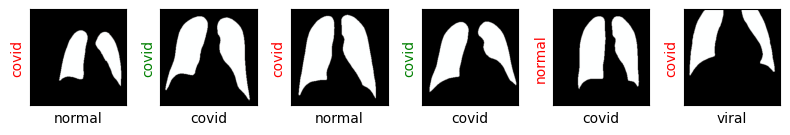

In [91]:
show_preds()


Accuracy: 0.3401
Precision: 0.6542
Recall: 0.3401
F1-score: 0.1821

Classification Report:
              precision    recall  f1-score   support

      normal       0.63      0.02      0.04      5004
       viral       1.00      0.00      0.00      5038
       covid       0.34      0.99      0.50      5111

    accuracy                           0.34     15153
   macro avg       0.66      0.34      0.18     15153
weighted avg       0.65      0.34      0.18     15153



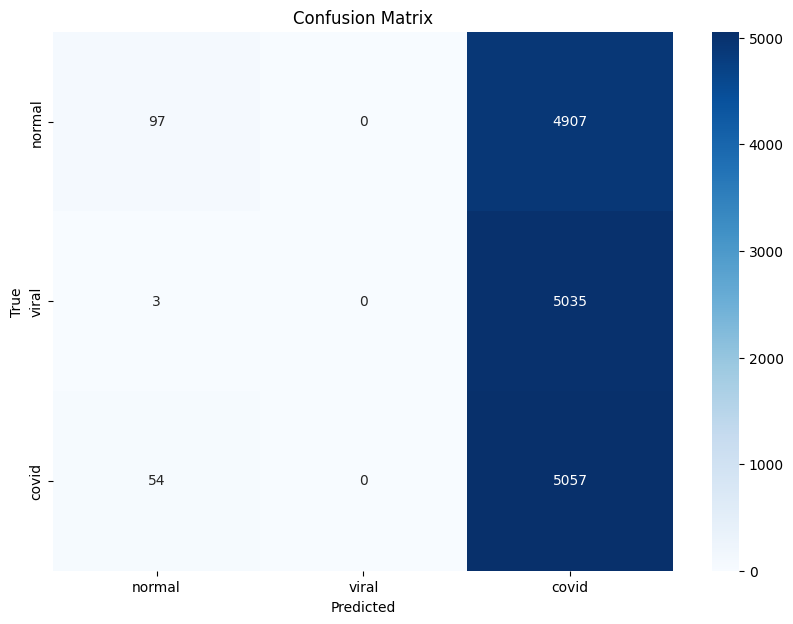

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model():
    resnet18.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dl_test:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))

    # Plotting the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the evaluation function
evaluate_model()
